In [109]:
!source /opt/ros/humble/setup.bash

In [110]:
import numpy as np
from numpy.typing import NDArray
import threading
import time
from PI_controller_class import PIController

class PurePursuitNode():
    def __init__(self) -> None:
        # パラメータの取得
        self.speed = 1.0 # 速度[m/s]
        self.lookahead_distance = 0.5 # 先行距離[m]
        self.path_p_gain = 0.05 # 経路法線方向のP制御ゲイン
        self.angle_p_gain = 0.5 # 角度P制御ゲイン
        self.angle_i_gain = 0.0 # 角度I制御ゲイン
        self.distance_threshold = 0.2 # 距離閾値[m]
        self.angle_controller = PIController(self.angle_p_gain, self.angle_i_gain, max_input=1.0)
        # 準静的な変数の初期化
        self.path_data: NDArray[np.float64] = None # np.array([[x, y, theta], [x, y, theta]])の形
        self.indices: NDArray[np.int8] = np.array([]) # np.array([1, 2, 3])の形
        self.tangents: NDArray[np.float64] = None # np.array([[0.0, 0.0], [0.0, 0.0]])の形
        self.angles = None # np.array([0.0, 0.0, 0.0])の形
        self.max_angle: float = 0.0
        # 動的な変数の初期化
        self.robot_pose: NDArray[np.float64] = np.array([0.0, 0.0, 0.0]) # np.array([x, y, theta])の形
        self.pure_pursuit_vel: NDArray[np.float64] = np.array([0.0, 0.0]) # np.array([v_x, v_y])の形
        self.current_path_index: int = 0
        self.closest_index: int = 0
        self.current_speed = self.speed
        self.current_lookahead_distance = self.lookahead_distance
        # action serverのための変数の初期化
        self.goal_handle = None # GoalHandleの初期化
        self.result_msg = None # Resultの初期化
        self.start_pure_pursuit = False # pure pursuitの開始フラグの初期化
        self.completed = False # 完了フラグの初期化
        self.goal_event = threading.Event()

    async def execute_callback (self, goal_handle) -> None:
        self.goal_event.clear()  # イベントフラグをリセット
        self.completed = False # 完了フラグをリセット
        self.result_msg = None # Resultをリセット
        self.start_pure_pursuit = True # pure pursuitの開始フラグをセット
        self.goal_handle = goal_handle
        # 経路データの受け取りと格納
        path_msgs = goal_handle.request.path.path
        # 特定の点のインデックスの受け取りと格納
        self.indices = np.array(goal_handle.request.feedback_indices)
        self.get_logger().info("path data has been received")
        # 経路データをnumpy配列に変換
        self.path_data = np.array([[msg.x, msg.y, msg.theta] for msg in path_msgs])
        self.tangents = self.compute_tangents (self.path_data) # 接ベクトルの計算と格納
        self.angles, self.max_angle = self.compute_thetas (self.tangents) # 角度の計算と格納

        self.get_logger().info("path data has been initialized")
        self.get_logger().debug(f"path_data: {self.path_data}")
        self.get_logger().debug(f"indices: {self.indices}")
        # 新しいスレッドで条件が満たされるのを待つ
        threading.Thread(target=self.wait_for_condition).start()
        self.goal_event.wait()  # 条件が満たされるまで待つ
        goal_handle.succeed()
        return self.result_msg

    def pose_callback (self, msg) -> None:
        self.get_logger().info(f"start_pure_pursuit: {self.start_pure_pursuit}")
        # pure pursuitの開始フラグが立っていない場合は何もしない
        if not self.start_pure_pursuit:
            self.get_logger().warn("pure pursuit has not started yet")
            return
        elif (self.goal_handle is not None) and (not self.goal_handle.is_active):
            self.get_logger().warn("no active goal")
            return
        
        # 位置の受け取りと格納
        self.robot_pose = self.pose_to_array(msg) # 位置の格納
        self.get_logger().debug(f"x: {self.robot_pose[0]}, y: {self.robot_pose[1]}, theta: {self.robot_pose[2]}")
        # 先行点の計算
        lookahead_point: NDArray[np.float64] = None
        lookahead_point, self.current_path_index = self.find_lookahead_point (self.robot_pose, self.path_data, self.lookahead_distance, self.distance_threshold, self.robot_pose[:2], self.current_path_index)
        self.get_logger().info(f"lookahead_point: {lookahead_point}")
        # 最も近い点の計算
        closest_point: NDArray[np.float64] = None
        closest_point, self.closest_index = self.find_closest_point (self.robot_pose, self.path_data, self.robot_pose, self.closest_index)
        # 速度入力の計算
        vel_msg = self.速度入力の計算 (self.robot_pose, lookahead_point, closest_point, self.lookahead_distance, self.speed)
        self.vel_pub.publish(vel_msg) # 速度入力パブリッシュ
        self.get_logger().debug(f"v_x: {vel_msg.linear.x}, v_y: {vel_msg.linear.y}, omega: {vel_msg.angular.z}")
        # 完了処理
        if self.closest_index in self.indices:
            # フィードバックにインデックスを返す
            feedback_msg = PathAndFeedback.Feedback()
            feedback_msg.current_index = self.closest_index
            self.goal_handle.publish_feedback(feedback_msg)
            self.get_logger().info(f"feedback: {self.closest_index}")
        elif self.distance(self.robot_pose[:2], self.path_data[-1][:2]) < self.distance_threshold:
            # 完了処理を行う
            self.result_msg = PathAndFeedback.Result()
            self.result_msg.final_index = self.closest_index
            self.completed = True

    def find_lookahead_point (self,
            robot_pose: NDArray[np.float64], 
            path_data: NDArray[np.float64], 
            previous_index: int,
            lookahead_distance: float,
        ) -> tuple[NDArray[np.float64], NDArray[np.float64], int]:
        closest_index = previous_index
        lookahead_point = None

        # 最も近い点の検索
        start_index = previous_index # 検索範囲の開始インデックス
        distances = np.linalg.norm(path_data[:, :2] - robot_pose[:2], axis=1)
        closest_index = np.argmin(distances[start_index:]) + start_index
        closest_point = path_data[closest_index]

        lookahead_index = closest_index + np.argmin(np.abs(distances[closest_index:] - lookahead_distance))
        lookahead_point = path_data[lookahead_index]

        return lookahead_point, closest_point, closest_index

    def compute_velocity (self,
            robot_pose: NDArray[np.float64], 
            lookahead_point: NDArray[np.float64],
            closest_point: NDArray[np.float64],
            speed: float
        ) -> NDArray[np.float64]:
        self.pure_pursuit_vel = self.calc_pure_pursuit_vel (
            robot_pose, lookahead_point, speed)
        p_control_vel: NDArray[np.float64] = self.compute_path_P_input (
            robot_pose, closest_point, self.closest_index, self.angles, self.max_angle, self.path_p_gain)
        # p_input_angle: float = self.compute_p_input (closest_point, self.closest_index, robot_pose, self.path_p_gain, self.tangents)
        omega: float = self.compute_angle_PI (robot_pose, closest_point, self.dt)
        vel: NDArray[np.float64] = np.array([0.0, 0.0, 0.0])
        vel[:2] = self.pure_pursuit_vel + p_control_vel
        # vel[:2] = self.rotation_matrix(p_input_angle) @ self.pure_pursuit_vel[:2]
        vel[2] = omega
        return vel

    def calc_pure_pursuit_vel (self,
            robot_pose: NDArray[np.float64], 
            lookahead_point: NDArray[np.float64], 
            speed: float, 
        ) -> NDArray[np.float64]:
        # 速度入力の計算
        vel: NDArray[np.float64] = np.array([0.0, 0.0])
        direction: NDArray[np.float64] = lookahead_point[:2] - robot_pose[:2]
        if np.linalg.norm(direction) > 0.0:
            direction /= np.linalg.norm(direction) # 方向ベクトルの正規化
        vel = direction * speed
        return vel

    def compute_path_P_input (self, 
            robot_pose: NDArray[np.float64], 
            closest_point: NDArray[np.float64],
            closest_index: int,
            angles: NDArray[np.float64],
            max_angle: float,
            path_p_gain: float
        ) -> NDArray[np.float64]:
        # p_input_vel = path_p_gain * (closest_point - robot_position)
        p_input_vel = path_p_gain * (1.0 + (1.0 / 10.0 - 1.0) * angles[closest_index] / max_angle) * (closest_point - robot_pose)[:2]
        return p_input_vel
    
    def compute_p_input (self, 
            closest_point: NDArray[np.float64], 
            closest_index: int,
            robot_pose: NDArray[np.float64], 
            path_p_gain: float,
            tangents: NDArray[np.float64],
        ) -> float:
        p_input_angle = path_p_gain * np.dot((closest_point - robot_pose)[:2], self.rotation_matrix(np.pi) @ tangents[closest_index][:2])
        return p_input_angle

    def compute_angle_PI (self, robot_pose: NDArray[np.float64], closest_point: NDArray[np.float64], dt: float = 0.1) -> float:
        return self.angle_controller.update(closest_point[2], robot_pose[2], dt)

    def compute_tangents (self, path_data: NDArray[np.float64]) -> NDArray[np.float64]:
        # 接ベクトルの計算
        path_x = path_data[:, 0]
        path_y = path_data[:, 1]
        tangents = np.array([np.gradient(path_x), np.gradient(path_y)]).T  # 各点における接ベクトル
        return tangents

    def compute_angles (self, tangents: NDArray[np.float64]) -> tuple[NDArray[np.float64], float]:
        angles = []

        # 隣接する接ベクトル間の角度を計算する
        for i in range(len(tangents) - 1):
            dot_product = np.dot(tangents[i], tangents[i+1])
            norms_product = np.linalg.norm(tangents[i]) * np.linalg.norm(tangents[i+1])
            # 内積の値を-1と1の間に制限する
            cos_angle = np.clip(dot_product / norms_product, -1.0, 1.0)
            angle = np.arccos(cos_angle)
            angles.append(angle)
        angles.append(angle) # close

        max_angle = np.max(angles)

        return angles, max_angle
    
    def change_speed_lookahead_distance (self, 
            path_data: NDArray[np.float64],
            lookahead_distance: float,
            current_LA_dist: float,
            speed: float,
            current_speed: float,
            angles: NDArray[np.float64],
            max_angle: float,
            closest_point: NDArray[np.float64],
            closest_index: int,
        ):
        path_x = path_data[:, 0]
        path_y = path_data[:, 1]
        dist = np.sqrt((path_x[-1] - closest_point[0])**2 + (path_y[-1] - closest_point[1])**2)
        # if 最終点と現在の先行点の距離がしきい値以下なら:
        if dist < lookahead_distance:
            # change lookahead_distance and speed as propotion to distance between lookahead_point and final path point
            current_LA_dist = lookahead_distance * (1.0 - np.cos(np.pi * dist / lookahead_distance)) / 2.0
            # current_LA_dist = lookahead_distance * (dist / 2.0 / lookahead_distance)
            current_speed = speed * dist / lookahead_distance / 2.0
            # current_speed = speed * (1.0 - np.cos(np.pi * dist / lookahead_distance / 2.0)) / 2.0
        else : # 曲率に応じて変化させる
            # current_LA_dist = lookahead_distance / 2 * (1 - curvatures[closest_index] / max_curvature) + lookahead_distance * curvatures[closest_index] / max_curvature
            target_speed = speed * (1.0 + (1.0 / 3.0 - 1.0) * angles[closest_index] / max_angle)
            current_speed = self.first_order_vel(current_speed, target_speed, 1.0, 0.05, 0.5)
        return current_speed, current_LA_dist

    # def pose_to_array (self, msg: PoseStamped) -> NDArray[np.float64]:
    #     robot_pose: NDArray[np.float64] = np.array([0.0, 0.0, 0.0])
    #     robot_pose[0] = msg.pose.position.x
    #     robot_pose[1] = msg.pose.position.y
    #     q = np.array([
    #         msg.pose.orientation.x,
    #         msg.pose.orientation.y,
    #         msg.pose.orientation.z,
    #         msg.pose.orientation.w
    #     ])
    #     robot_pose[2] = self.quaternion_to_yaw(q)
    #     return robot_pose

    def distance (self, p1: NDArray[np.float64], p2: NDArray[np.float64]) -> float:
        # 2点間の距離を計算
        return np.linalg.norm(p1 - p2)
    
    def interpolate_point(self,
            p1: NDArray[np.float64], p2: NDArray[np.float64], ratio: float) -> NDArray[np.float64]:
        """2点間を指定された比率で補間する"""
        return p1 + ratio * (p2 - p1)
        
    def quaternion_to_yaw(self, q: NDArray[np.float64]) -> float:
        """
        description: クォータニオンからヨー角(ズ軸回りの回転)を計算する。
        q: クォータニオンを [x, y, z, w] の形で表したnumpy配列
        """
        # クォータニオンの要素を抽出
        x, y, z, w = q
        
        # ヨー (z-axis rotation)
        siny_cosp = 2 * (w * z + x * y)
        cosy_cosp = 1 - 2 * (y**2 + z**2)
        yaw = np.arctan2(siny_cosp, cosy_cosp)
        
        return yaw
    
    def first_order_vel(self, previous_vel, input_vel, K, dt, tau):
        new_vel = (tau * previous_vel + K * dt * input_vel) / (tau + dt)
        return new_vel

-[x] give bezier curve `radius` as list for changing the radius of each point
-[] give max_speed and change speed of each curve based on radius

In [20]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def generate_bezier_curve(
        p0, p1, p2, p3, # 4つの制御点 (np.array([x, y])型)
        resolution: int = 20
    ) -> NDArray[np.float64]:
    t_values = np.linspace(0, 1, num=resolution)
    points: NDArray[np.float64] = np.zeros((resolution, 2))

    for i, t in enumerate(t_values):
        x = (1-t)**3 * p0[0] + 3*(1-t)**2 * t * p1[0] + 3*(1-t) * t**2 * p2[0] + t**3 * p3[0]
        y = (1-t)**3 * p0[1] + 3*(1-t)**2 * t * p1[1] + 3*(1-t) * t**2 * p2[1] + t**3 * p3[1]
        points[i] = np.array([x, y])

    return points

def bezier_from_3_points(
        p0: NDArray[np.float64],
        p1: NDArray[np.float64],
        p2: NDArray[np.float64],
        resolution: int = 20,
        radius: float = 0.3
    ) -> tuple[NDArray[np.float64], NDArray[np.float64], NDArray[np.float64]]:
    # 前後の点からのベクトル
    vec1 = (p1 - p0) / np.linalg.norm(p1 - p0)
    vec2 = (p2 - p1) / np.linalg.norm(p2 - p1)

    # 制御点1 (終点の前の制御点)
    ctrl1 = p1 - vec1 * radius

    # ベジェ曲線の制御点
    ctrl2 = p1 - vec1 * radius * 0.5
    ctrl3 = p1 + vec2 * radius * 0.5
    ctrl4 = p1 + vec2 * radius

    # ベジェ曲線部分の生成
    return generate_bezier_curve(ctrl1, ctrl2, ctrl3, ctrl4, resolution), ctrl1, ctrl4

def generate_path(
        points: NDArray[np.float64],
        radiuses: NDArray[np.float64], # radius of each curve
        resolution: int = 20,
    ) -> NDArray[np.float64]:
    # description: generate 2D path from points in poses_and_commands
    path: NDArray[np.float64] = np.zeros((0, 2))

    # 最初のベジェ曲線のスタート点を設定
    p0 = points[0]  # 最初の点
    p1 = points[1]  # 二番目の点

    # p0からp1へのベクトル
    vec0 = p1 - p0
    norm_vec0 = vec0 / np.linalg.norm(vec0) # ベクトルの正規化

    # ベジェ曲線の最初の制御点を計算（ここでは、p1からの距離に基づく）
    first_bezier_start = p1 - norm_vec0 * radiuses[0]

    # 最初の直線セグメントをpathに追加
    line_x_values = np.linspace(p0[0], first_bezier_start[0], num=resolution, endpoint=True)
    line_y_values = np.linspace(p0[1], first_bezier_start[1], num=resolution, endpoint=True)
    path = np.append(path, np.column_stack((line_x_values, line_y_values)), axis=0)

    for i in range(1, len(points)-1):
        p0 = points[i - 1]
        p1 = points[i]
        p2 = points[i + 1]
        bezier, ctrl1, ctrl4 = bezier_from_3_points(p0, p1, p2, resolution, radiuses[i])

        if i != 1:
            line_x_values = np.linspace(pre_ctrl4[0], ctrl1[0], num=resolution, endpoint=True)
            line_y_values = np.linspace(pre_ctrl4[1], ctrl1[1], num=resolution, endpoint=True)
            path = np.append(path, np.column_stack((line_x_values, line_y_values)), axis=0)

        path = np.append(path, bezier, axis=0)

        pre_ctrl4 = ctrl4

    # 最後の直線部分を追加
    final_line_start = path[-1]
    final_line_end = points[-1]
    line_x_values = np.linspace(final_line_start[0], final_line_end[0], num=resolution, endpoint=True)
    line_y_values = np.linspace(final_line_start[1], final_line_end[1], num=resolution, endpoint=True)
    path = np.append(path, np.column_stack((line_x_values, line_y_values)), axis=0)

    return path

def generate_angles(
        path: NDArray[np.float64],
        indices: NDArray[np.int32],
        specified_angles: NDArray[np.float64]
    ) -> NDArray[np.float64]:
    # pathの各ポイントに対する角度データを生成
    angles = np.zeros(len(path))
    for i in range(len(indices) - 1):
        # indices[i]からindices[i+1]までの間の角度を補間
        start_index = indices[i]
        end_index = indices[i + 1]
        # 指定された角度から次の角度への補間を行い、その区間の長さに合わせて解像度を調整
        angles[start_index:end_index] = np.linspace(
            specified_angles[i], specified_angles[i + 1], num=end_index - start_index)

    # 最後の指定された角度を、経路の残りの部分に適用
    if indices[-1] < len(path):
        angles[indices[-1]:] = specified_angles[-1]

    return angles

def interpolate_angle(
        start_angle: float = 0.0,
        end_angle: float = 0.0,
        resolution: int = 20
    ) -> NDArray[np.float64]:
    # description: interpolate angle through all points in poses_and_commands
    return np.linspace(start_angle, end_angle, num=resolution)

def extract_indices(
        path: NDArray[np.float64],
        specified_points: NDArray[np.float64]
    ) -> NDArray[np.int32]:
    indices = np.array([
        np.argmin(np.linalg.norm(path - point, axis=1))
        for point in specified_points
    ])
    return indices

def interpolate_speed(
        poses: NDArray[np.float64],
        path: NDArray[np.float64],
        radiuses: NDArray[np.float64],
        indices: NDArray[np.int32],
        max_speed: float,
        speed_rates: NDArray[np.float64]
    ) -> NDArray[np.float64]:
    speeds = np.zeros(len(path))
    curve_end_index = 0

    plt.figure(figsize=(8, 6))

    for i in range(len(indices) - 2):
        before_curve_index = np.argmin(np.abs(np.linalg.norm(poses[i+1][:2] - path[:indices[i+1]], axis=1) - radiuses[i+1] * 2.5))
        if i != 0:
            speeds[curve_end_index:before_curve_index] = np.array([max_speed for _ in range(before_curve_index - curve_end_index)])
        else:
            speeds[curve_end_index:before_curve_index] = np.linspace(0, max_speed * speed_rates[i], num=before_curve_index - curve_end_index)
        curve_index = np.argmin(np.abs(np.linalg.norm(poses[i+1][:2] - path[:indices[i+1]], axis=1) - radiuses[i+1]))
        speeds[before_curve_index:curve_index] = np.linspace(max_speed, max_speed * speed_rates[i+1], num=curve_index - before_curve_index)
        speeds[curve_index:indices[i+1]] = np.array([max_speed * speed_rates[i+1] for _ in range(indices[i+1] - curve_index)])
        curve_end_index = np.argmin(np.abs(np.linalg.norm(poses[i+1][:2] - path[indices[i+1]:indices[i+2]], axis=1) - radiuses[i+1])) + indices[i+1]
        if i != len(indices) - 3:
            speeds[indices[i+1]:curve_end_index] = np.linspace(max_speed * speed_rates[i+1], max_speed, num=curve_end_index - indices[i+1])
        else:
            speeds[indices[i+1]:curve_end_index] = np.linspace(max_speed * speed_rates[i+1], max_speed * speed_rates[i+1], num=curve_end_index - indices[i+1])

        plt.axvline(x=before_curve_index, color='r', linestyle='--')
        plt.axvline(x=curve_index, color='r', linestyle='--')
        plt.axvline(x=curve_end_index, color='r', linestyle='--')

    # speeds[curve_end_index:] = max_speed * np.cos(np.pi * np.linspace(0, 1, num=len(speeds[curve_end_index:])))
    speeds[curve_end_index:] = np.linspace(max_speed * speed_rates[-2], 0, num=len(speeds[curve_end_index:]))

    plt.plot(speeds, label='Speeds')
    plt.legend()
    plt.show()

    return speeds

def generate_and_save_path(poses, max_speed, commands, path_number: int, resolution: int) -> None:
    # description: generate path and save it to a file
    specified_points = np.array([[item[0], item[1]] for item in poses])
    specified_angles = np.array([item[2] for item in poses])
    radiuses = np.array([item[3] for item in poses])
    speed_rates = np.array([item[4] for item in poses])
    path = generate_path(points=specified_points, radiuses=radiuses, resolution=resolution)
    indices = extract_indices(path, specified_points)
    print(indices)
    angles = generate_angles(path, indices, specified_angles)

    speeds = interpolate_speed(poses, path, radiuses, indices, max_speed, speed_rates)
    # speeds = np.array([max_speed for _ in range(len(path))])
    speeds = gaussian_filter1d(speeds, sigma=3)
    print(len(speeds) - len(path))
    # save
    data_to_save = np.hstack((path, angles.reshape(-1, 1), speeds.reshape(-1, 1)))
    if len(commands) == len(poses):
        indices_and_commands = np.hstack((indices.reshape(-1, 1), commands))
    else:
        print("size of commands is not equal to size of poses")
        return

    path_file = f"../csv/path{path_number}.csv"
    indices_and_commands_file = f"../csv/indices_and_commands{path_number}.csv"

    print(f"Saving path to {path_file}")
    print(f"Saving indices and commands to {indices_and_commands_file}")

    # CSVファイルに保存
    np.savetxt(path_file, data_to_save, delimiter=",", fmt='%s', comments='', header='x,y,theta,speed')
    np.savetxt(indices_and_commands_file, indices_and_commands, delimiter=",", fmt='%s', comments='', header='index,command1,command2,command3,set_pose_flag')

    plt.figure(figsize=(8, 6))
    plt.quiver(path[:, 0], path[:, 1], -np.sin(angles), np.cos(angles), scale=20, color='r', alpha=0.5)
    plt.plot(path[:, 0], path[:, 1], 'b-', label='Path')
    # plt.scatter(path[:, 0], path[:, 1], color='g', zorder=5, label='Specified Points')
    plt.scatter(path[indices, 0], path[indices, 1], color='g', zorder=5, label='Specified Points')

    for i in range(len(indices) - 2):
        before_curve_index = np.argmin(np.abs(np.linalg.norm(poses[i+1][:2] - path[:indices[i+1]], axis=1) - radiuses[i+1] * 2.5))
        curve_index = np.argmin(np.abs(np.linalg.norm(poses[i+1][:2] - path[:indices[i+1]], axis=1) - radiuses[i+1]))
        curve_end_index = np.argmin(np.abs(np.linalg.norm(poses[i+1][:2] - path[indices[i+1]:indices[i+2]], axis=1) - radiuses[i+1])) + indices[i+1]

        plt.scatter(path[curve_index, 0], path[curve_index, 1], color='r', zorder=5)
        plt.scatter(path[curve_end_index, 0], path[curve_end_index, 1], color='r', zorder=5)
        plt.scatter(path[before_curve_index, 0], path[before_curve_index, 1], color='b', zorder=5)

        circ_x = poses[i+1][0] + radiuses[i+1] * np.cos(np.linspace(0, 2 * np.pi, num=100))
        circ_y = poses[i+1][1] + radiuses[i+1] * np.sin(np.linspace(0, 2 * np.pi, num=100))

        expanded_circ_x = poses[i+1][0] + radiuses[i+1] * np.cos(np.linspace(0, 2 * np.pi, num=100)) * 2.5
        expanded_circ_y = poses[i+1][1] + radiuses[i+1] * np.sin(np.linspace(0, 2 * np.pi, num=100)) * 2.5

        plt.plot(circ_x, circ_y, 'r--')
        plt.plot(expanded_circ_x, expanded_circ_y, 'r--')

    plt.title('Path with Interpolated Angles')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plt.plot(angles, label='Interpolated Angles')
    plt.plot(path[:, 0], label='X')
    plt.plot(path[:, 1], label='Y')
    plt.plot(speeds, label='Speeds')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

[  0  74 174 274 375 474 575 649]


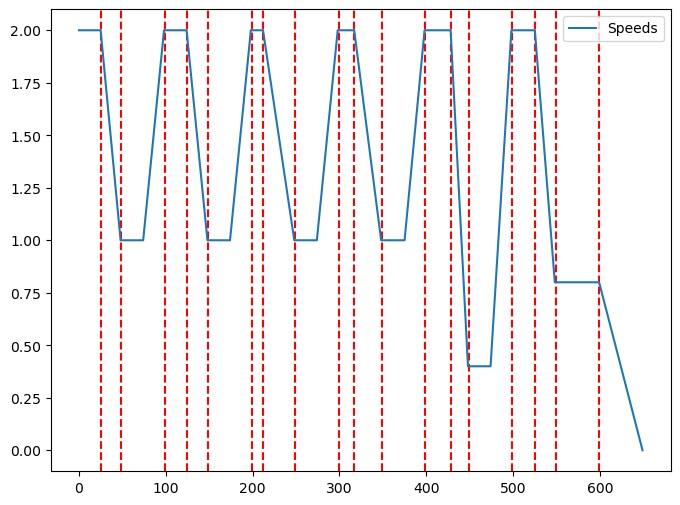

0
Saving path to ../csv/path1.csv
Saving indices and commands to ../csv/indices_and_commands1.csv


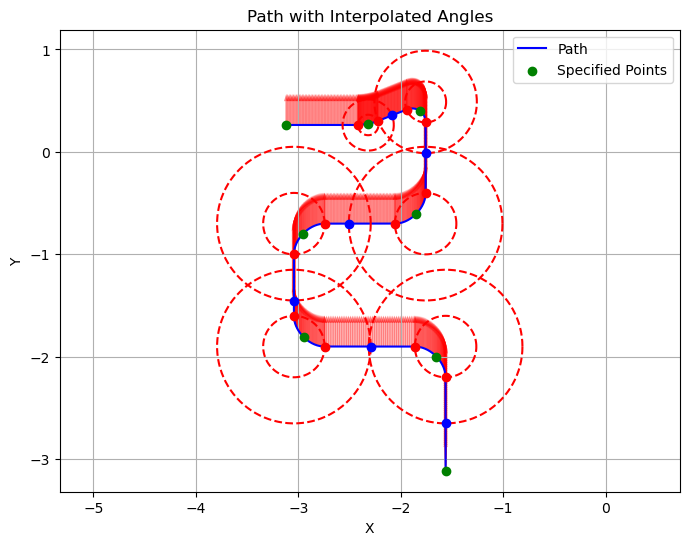

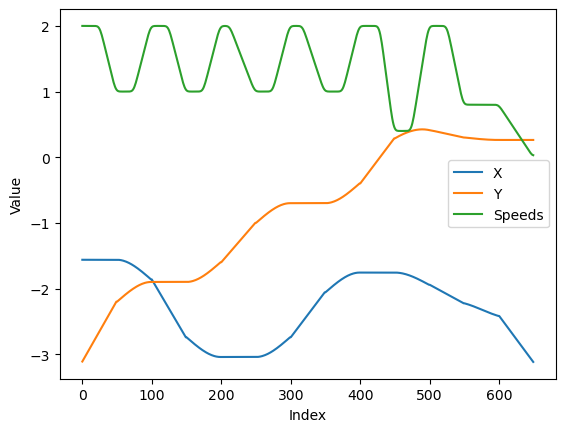

In [285]:
max_speed = 2.0 # 速度[m/s]
poses = np.array([ # x, y, theta, radius, speed_rate (normalized in [0, 1])
    [1.562, -3.112, 0.0, 0.3, 1.0],
    [1.562, -3.112 + 1.212, 0.0, 0.3, 0.5],
    [1.562 + 1.481, -3.112 + 1.212, 0.0, 0.3, 0.5],
    [1.562 + 1.481, -3.112 + 2.412, 0.0, 0.3, 0.5],
    [1.562 + 1.481 - 1.286, -3.112 + 2.412, 0.0, 0.3, 0.5],
    [1.562 + 1.481 - 1.286, -3.112 + 3.6, 0.0, 0.2, 0.2],
    [3.118 - 0.8, 0.26312, 0.0, 0.1, 0.4],
    [3.118, 0.26312, 0.0, 0.3, 0.0],
])

poses[:,0] = -poses[:,0]

commands = np.array([ # daiza_state, hina_state, bonbori_state, set_pose_flag
    [0, 1, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, True],
    [0, 0, False, True],
])

generate_and_save_path(poses, max_speed, commands, path_number=1, resolution=50)

[  0  74 149]


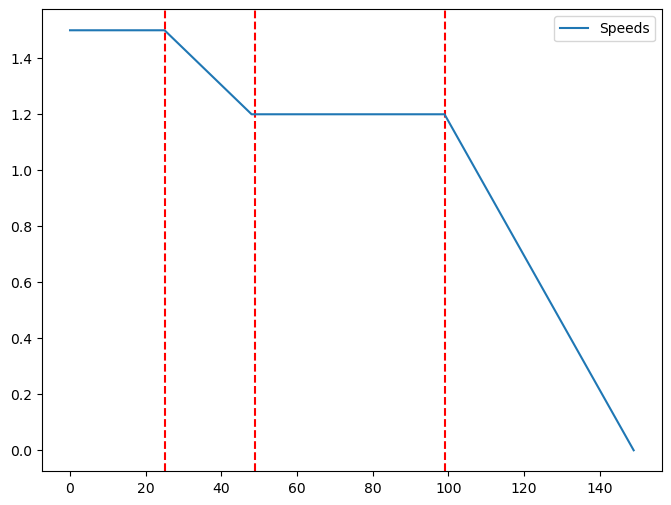

0
Saving path to ../csv/path2.csv
Saving indices and commands to ../csv/indices_and_commands2.csv


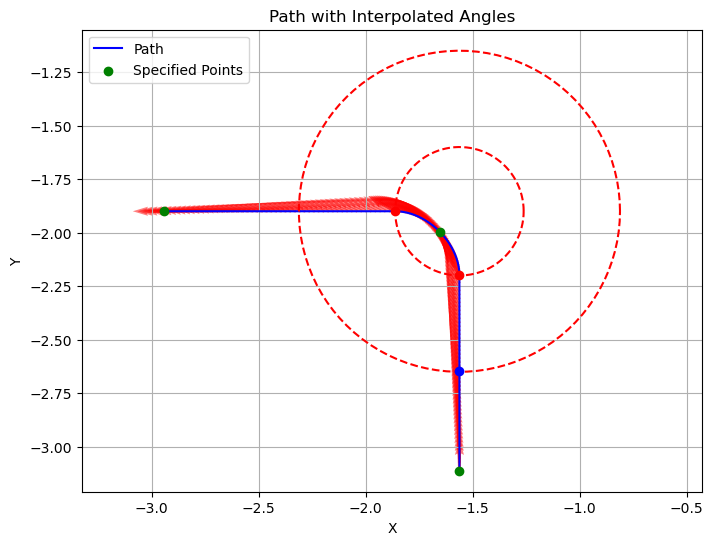

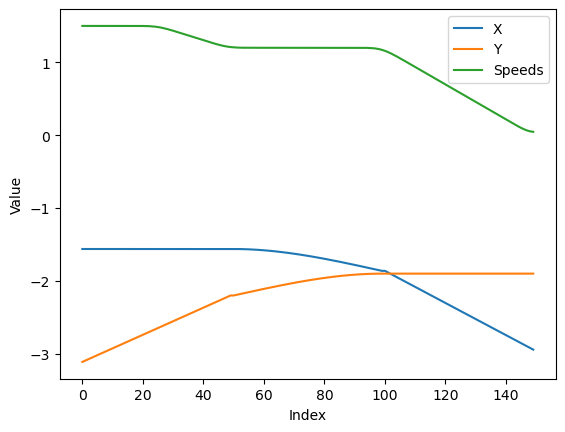

In [300]:
max_speed = 1.5 # 速度[m/s]
poses = np.array([ # x, y, theta, radius, speed_rate (normalized in [0, 1])
    [1.562, -3.112, 0.0, 0.3, 1.0],
    [1.562, -3.112 + 1.212, np.pi/4.0, 0.3, 0.8],
    [1.562 + 1.481 - 0.100, -3.112 + 1.212, np.pi/2.0, 0.3, 0.0],
])

poses[:,0] = -poses[:,0]

commands = np.array([ # daiza_state, hina_state, bonbori_state, set_pose_flag
    [0, 1, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
])

if len(poses) != len(commands):
    print("poses and commands have different lengths")

generate_and_save_path(poses, max_speed, commands, path_number=2, resolution=50)

[  0  74 175 275 374 475 549]


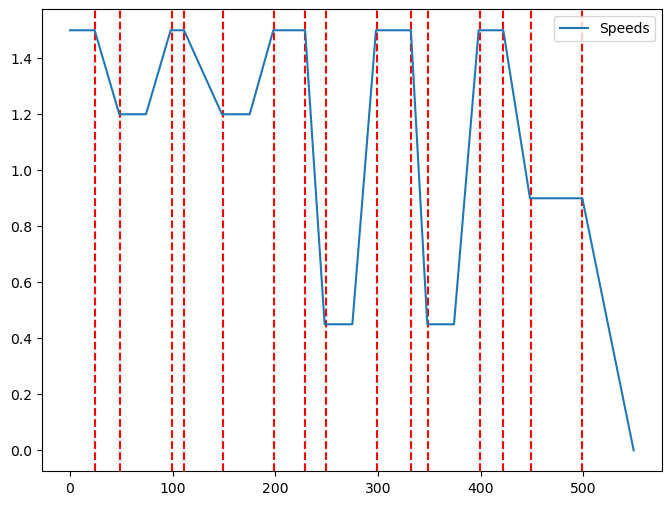

0
Saving path to ../csv/path3.csv
Saving indices and commands to ../csv/indices_and_commands3.csv


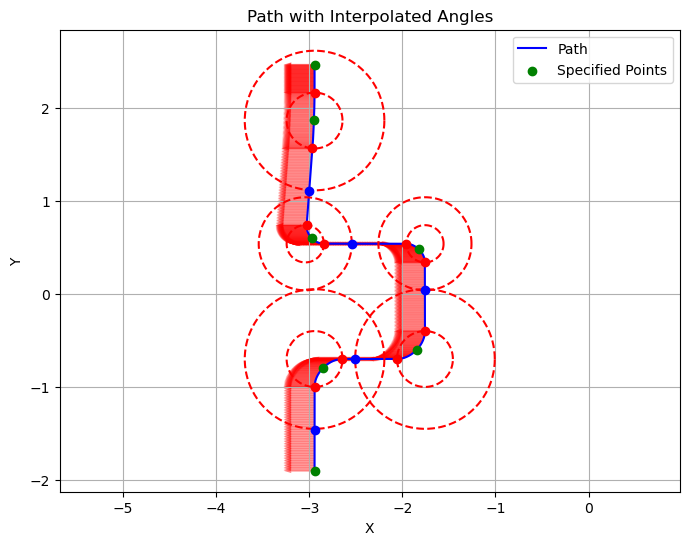

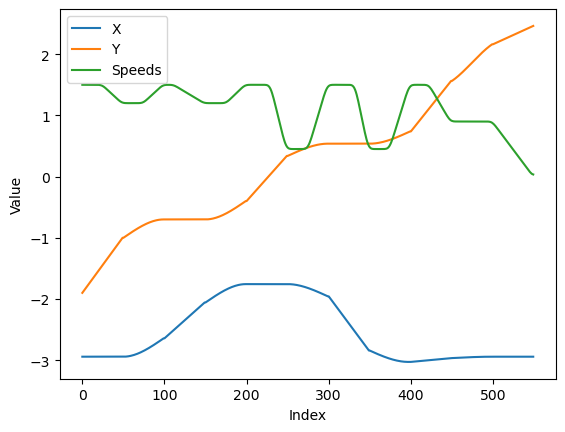

In [301]:
max_speed = 1.5 # 速度[m/s]
poses = np.array([ # x, y, theta, radius, speed_rate (normalized in [0, 1])
    [1.562 + 1.481 - 0.100, -3.112 + 1.212, np.pi/2.0, 0.3, 0.5],
    [1.562 + 1.481 - 0.100, -3.112 + 2.412, np.pi/2.0, 0.3, 0.8],
    [1.562 + 1.481 - 1.286, -3.112 + 2.412, np.pi/2.0, 0.3, 0.8],
    [1.562 + 1.481 - 1.286, -3.112 + 3.650, np.pi/2.0, 0.2, 0.3],
    [1.562 + 1.481, -3.112 + 3.650, np.pi/2.0, 0.2, 0.3],
    [2.943, -3.112 + 5.574 - 0.6, np.pi/2.0, 0.3, 0.6],
    [2.943, -3.112 + 5.574, np.pi/2.0, 0.1, 0.2],
])

poses[:,0] = -poses[:,0]

commands = np.array([ # daiza_state, hina_state, bonbori_state, set_pose_flag
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, True],
    [0, 0, False, True],
])

generate_and_save_path(poses, max_speed, commands, path_number=3, resolution=50)

[  0  75 175 249]


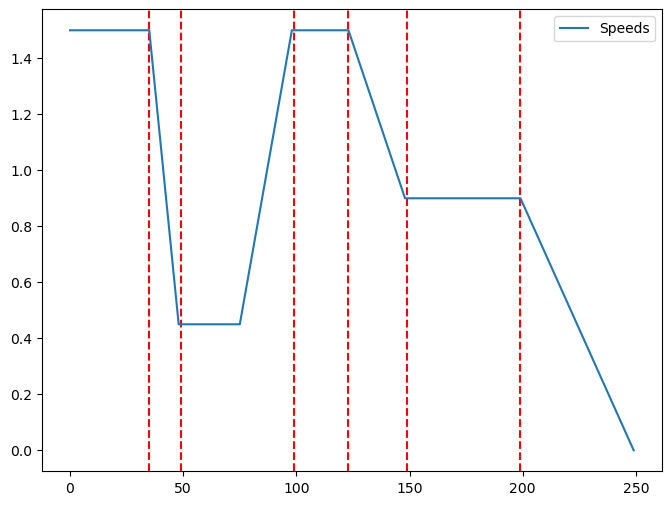

0
Saving path to ../csv/path3.csv
Saving indices and commands to ../csv/indices_and_commands3.csv


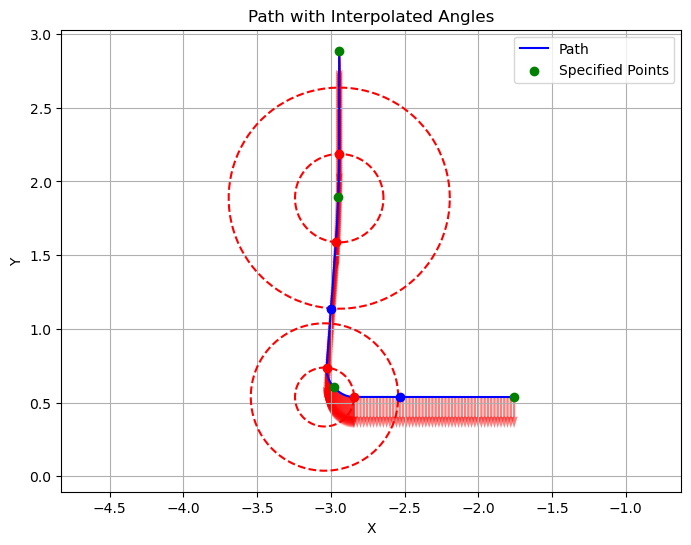

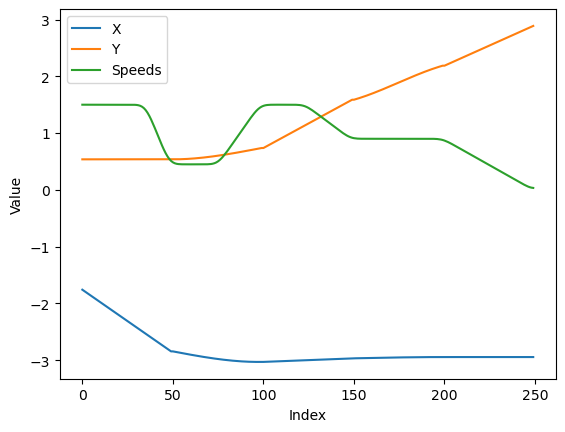

In [310]:
max_speed = 1.5 # 速度[m/s]
poses = np.array([ # x, y, theta, radius, speed_rate (normalized in [0, 1])
    [1.562 + 1.481 - 1.286, -3.112 + 3.650, np.pi, 0.2, 0.3],
    [1.562 + 1.481, -3.112 + 3.650, np.pi, 0.2, 0.3],
    [2.943, 2.887 - 1.0, np.pi, 0.3, 0.6],
    [2.943, 2.887, np.pi, 0.1, 0.2],
])

poses[:,0] = -poses[:,0]

commands = np.array([ # daiza_state, hina_state, bonbori_state, set_pose_flag
    [0, 1, False, False],
    [0, 0, False, False],
    [0, 12, False, True],
    [0, 0, False, True],
])

generate_and_save_path(poses, max_speed, commands, path_number=3, resolution=50)

[  0  75 175 249]


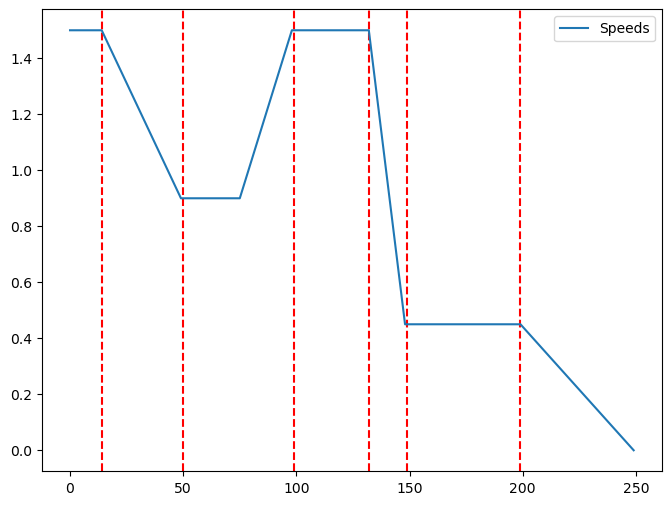

0
Saving path to ../csv/path4.csv
Saving indices and commands to ../csv/indices_and_commands4.csv


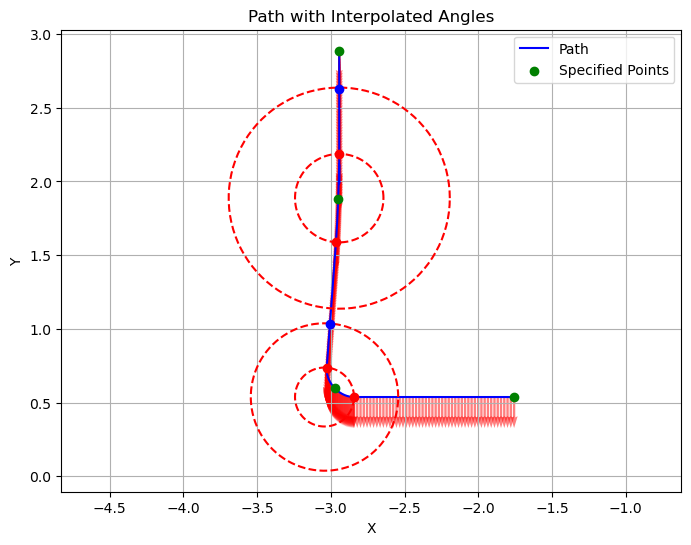

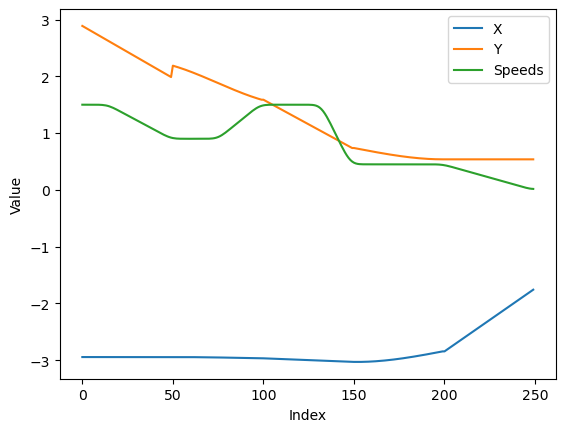

In [311]:
max_speed = 1.5 # 速度[m/s]
poses = np.array([ # x, y, theta, radius, speed_rate (normalized in [0, 1])
    [2.943, 2.887, np.pi, 0.1, 0.2],
    [2.943, 2.887 - 1.0, np.pi, 0.3, 0.6],
    [1.562 + 1.481, -3.112 + 3.650, np.pi, 0.2, 0.3],
    [1.562 + 1.481 - 1.286, -3.112 + 3.650, np.pi, 0.2, 0.3],
])

poses[:,0] = -poses[:,0]

commands = np.array([ # daiza_state, hina_state, bonbori_state, set_pose_flag
    [0, 13, False, False],
    [0, 0, False, False],
    [0, 0, False, True],
    [0, 14, False, True],
])

generate_and_save_path(poses, max_speed, commands, path_number=4, resolution=50)

[  0  75 174 249]


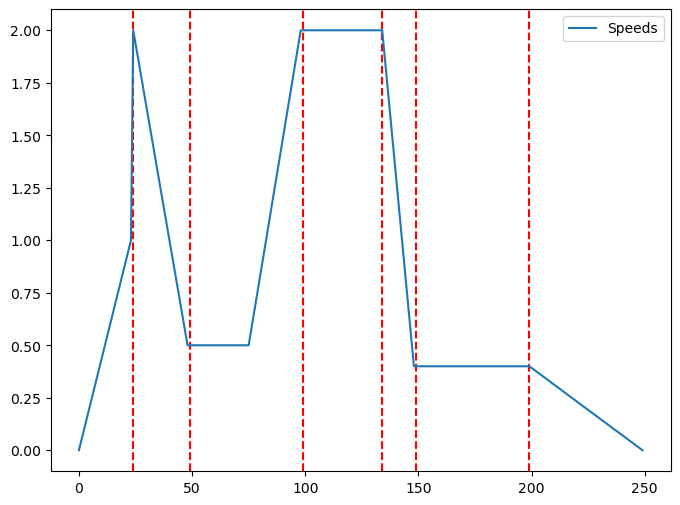

0
Saving path to ../csv/path1.csv
Saving indices and commands to ../csv/indices_and_commands1.csv


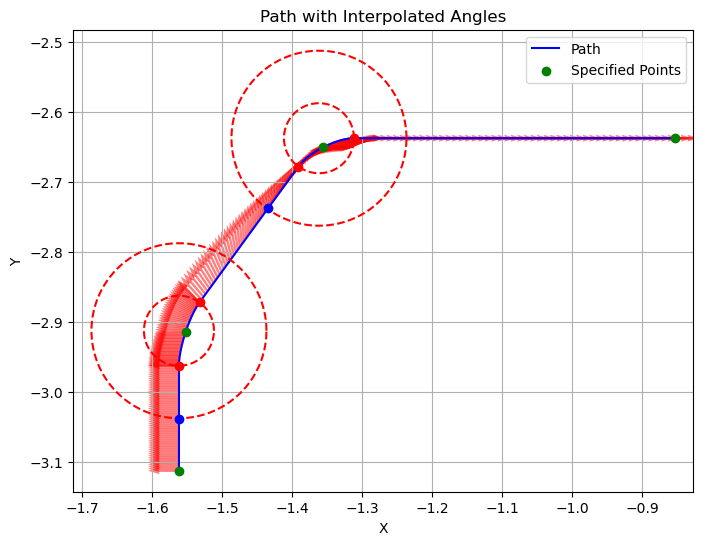

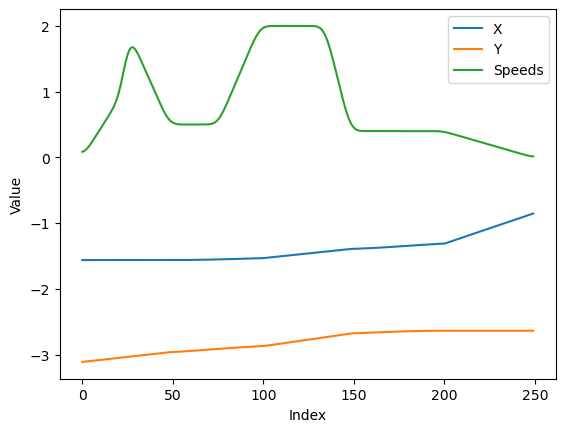

In [31]:
max_speed = 2.0 # 速度[m/s]
poses = np.array([
    [1.562, -3.112, -1.57, 0.05, 0.5],
    [1.562, -3.112 + 0.2, -1.57, 0.05, 0.25],
    [1.562 - 0.2, -2.637, 1.57, 0.05, 0.2],
    [0.854, -2.637, np.pi/2.0, 0.05, 0.75],
])

poses[:,0] = -poses[:,0]
poses[:,2] = -poses[:,2]

commands = np.array([
    [1, 0, False],
    [6, 0, False],
    [0, 0, False],
    [0, 0, False],
])

generate_and_save_path(poses, max_speed, commands, path_number=1, resolution=50)

[  0  75 175 274 349]


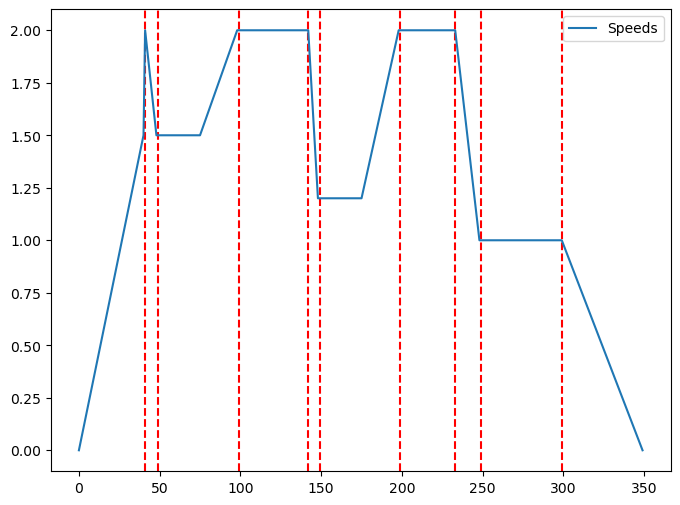

0
Saving path to ../csv/path2.csv
Saving indices and commands to ../csv/indices_and_commands2.csv


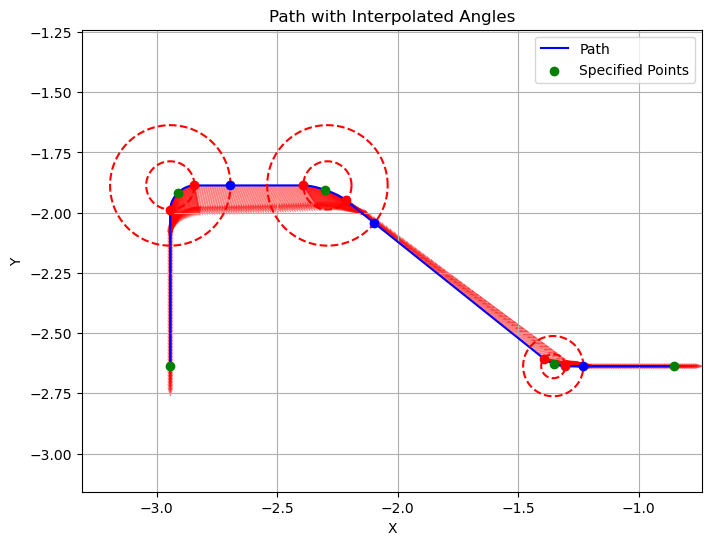

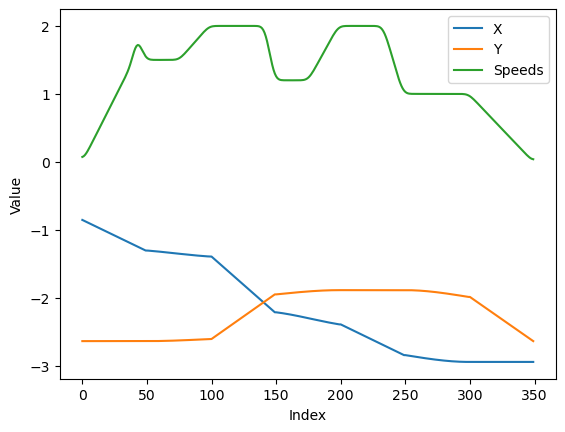

In [32]:
max_speed = 2.0 # 速度[m/s]
poses = np.array([
    [0.854, -2.637, np.pi/2.0, 0.05, 0.75],
    [0.854 + 0.5, -2.637, np.pi/2.0, 0.05, 0.75],
    [2.291, -1.887, np.pi*3.0/4.0, 0.1, 0.6],
    [2.943, -1.887, np.pi, 0.1, 0.5],
    [2.943, -2.637, np.pi, 0.1, 0.5],
])

poses[:, 0] = -poses[:, 0]
poses[:, 2] = -poses[:, 2]

commands = np.array([
    [7, 0, False],
    [0, 0, False],
    [0, 0, False],
    [0, 0, False],
    [9, 0, False],
])

generate_and_save_path(poses, max_speed=max_speed, commands=commands, path_number=2, resolution=50)

[  0  75 174 275 375 474 575 649]


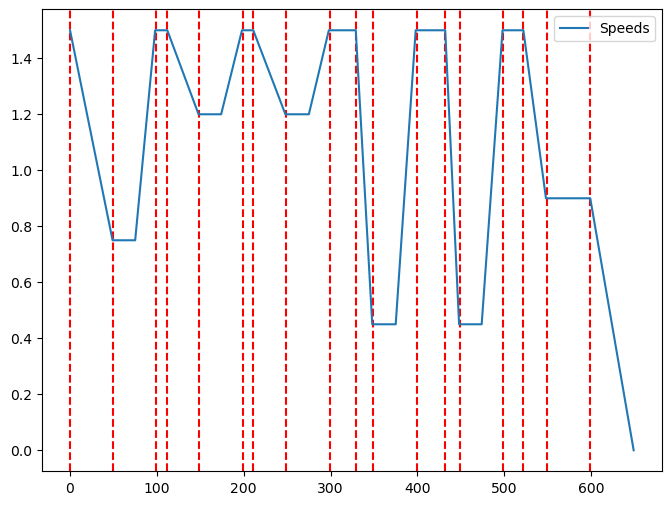

0
Saving path to ../csv/path3.csv
Saving indices and commands to ../csv/indices_and_commands3.csv


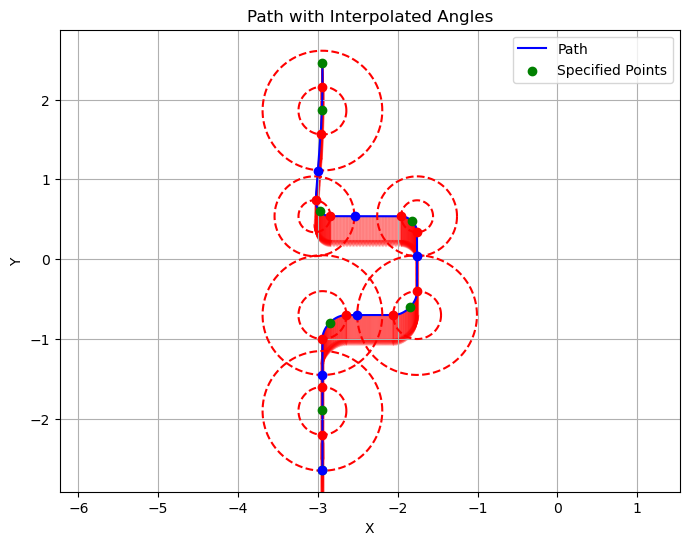

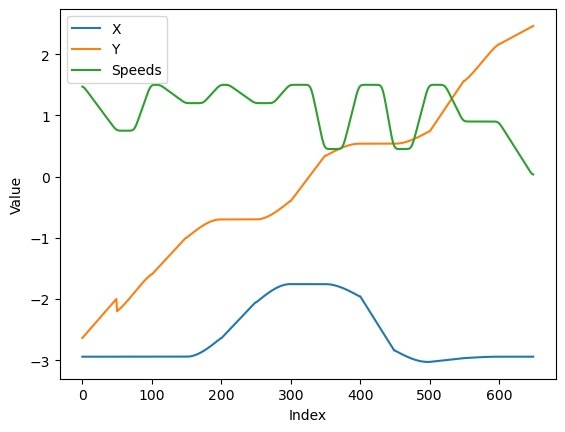

In [34]:
max_speed = 1.5 # 速度[m/s]
poses = np.array([ # x, y, theta, radius, speed_rate (normalized in [0, 1])
    [2.943, -2.637, np.pi, 0.1, 0.5],
    [1.562 + 1.481 - 0.100, -3.112 + 1.212, np.pi, 0.3, 0.5],
    [1.562 + 1.481 - 0.100, -3.112 + 2.412, np.pi, 0.3, 0.8],
    [1.562 + 1.481 - 1.286, -3.112 + 2.412, np.pi, 0.3, 0.8],
    [1.562 + 1.481 - 1.286, -3.112 + 3.650, np.pi, 0.2, 0.3],
    [1.562 + 1.481, -3.112 + 3.650, np.pi, 0.2, 0.3],
    [2.943, -3.112 + 5.574 - 0.6, np.pi, 0.3, 0.6],
    [2.943, -3.112 + 5.574, np.pi, 0.1, 0.2],
])

poses[:,0] = -poses[:,0]
poses[:,2] = -poses[:,2]

commands = np.array([ # daiza_state, hina_state, bonbori_state, set_pose_flag
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, False],
    [0, 0, False, True],
    [0, 0, False, True],
])

generate_and_save_path(poses, max_speed, commands, path_number=3, resolution=50)

[  0  49 149]


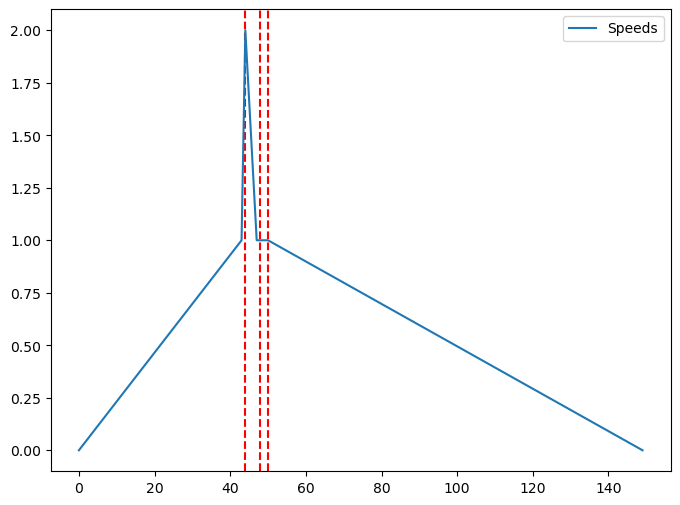

0
Saving path to ../csv/path1.csv
Saving indices and commands to ../csv/indices_and_commands1.csv


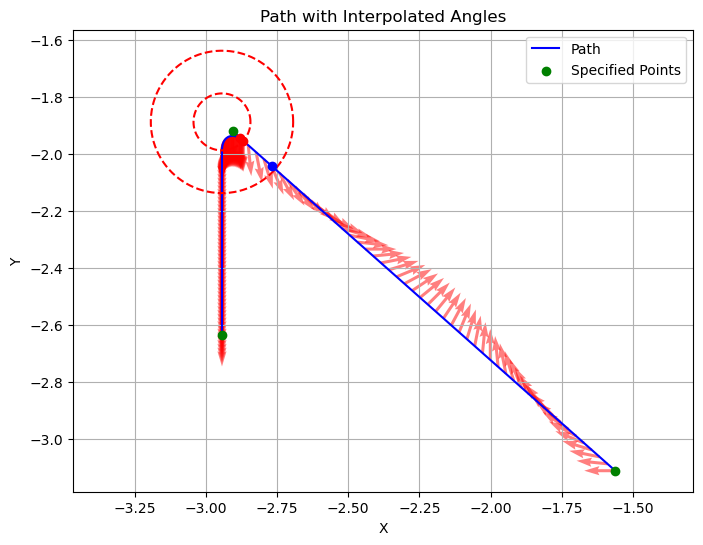

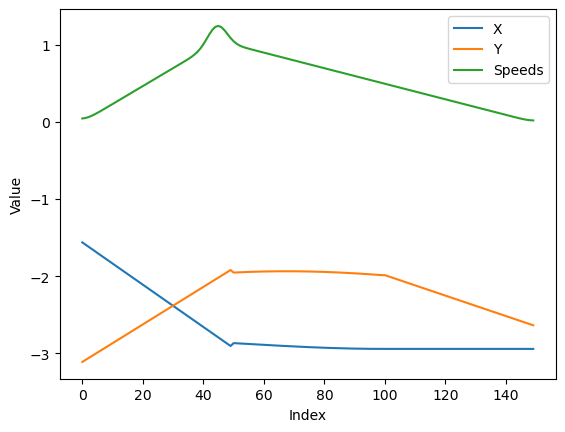

In [37]:
max_speed = 2.0 # 速度[m/s]
poses = np.array([
    [1.562, -3.112, -1.57, 0.05, 0.5],
    [2.943, -1.887, np.pi, 0.1, 0.5],
    [2.943, -1.887, np.pi, 0.1, 0.5],
    [2.943, -2.637, np.pi, 0.1, 0.5],
])

poses[:,0] = -poses[:,0]
poses[:,2] = -poses[:,2]

commands = np.array([
    [1, 0, False],
    [0, 0, False],
    [0, 0, False],
])

generate_and_save_path(poses, max_speed, commands, path_number=1, resolution=50)

In [16]:
def first_order_vel(previous_vel, input_vel, K, dt, tau):
    new_vel = (tau * previous_vel + K * dt * input_vel) / (tau + dt)
    return new_vel

def calc_wheel_vel(velocity: np.ndarray, omega: float, radius: float, length: float) -> list[float]:
    # 3輪のホイール速度を計算
    omega_1 = (-0.5 * velocity[0] + 0.8660254037844386 * velocity[1] + length * omega) / radius
    omega_2 = (-0.5 * velocity[0] - 0.8660254037844386 * velocity[1] + length * omega) / radius
    omega_3 = (velocity[0] + length * omega) / radius
    return [omega_1, omega_2, omega_3]

def twist_from_wheel_vel(omegas: list[float], radius: float, length: float, theta: float) -> np.ndarray:
    v_x = radius * 2.0 / 3.0 * (-omegas[0] + omegas[1] / 2.0 + omegas[2] / 2.0)
    v_y = radius * 2.0 / 3.0 * (-omegas[1] + omegas[2]) * 0.866025403784
    # ロボットの向きに合わせて速度ベクトルを回転
    vel_x = v_x * np.cos(theta - np.pi / 3.0) - v_y * np.sin(theta - np.pi / 3.0)
    vel_y = v_x * np.sin(theta - np.pi / 3.0) + v_y * np.cos(theta - np.pi / 3.0)
    omega = radius * (omegas[0] + omegas[1] + omegas[2]) / 3.0 / length
    return np.array([vel_x, vel_y]), omega

# 1次遅れ系で速度ベクトルを更新する関数
def update_velocity(pre_velocity_vector, pre_omega, target_velocity_vector, target_omega, dt, tau, theta):
    pre_omegas: list[float] = calc_wheel_vel(pre_velocity_vector, pre_omega, 0.0508, 0.400)
    omegas: list[float] = calc_wheel_vel(target_velocity_vector, target_omega, 0.0508, 0.400)
    resp_omegas: list[float] = [0.0, 0.0, 0.0]
    resp_omegas[0] = first_order_vel(pre_omegas[0], omegas[0], K=1.0, dt=dt, tau=tau)
    resp_omegas[1] = first_order_vel(pre_omegas[1], omegas[1], K=1.1, dt=dt, tau=tau * 1.01)
    resp_omegas[2] = first_order_vel(pre_omegas[2], omegas[2], K=0.9, dt=dt, tau=tau * 0.99)
    new_velocity_vector, robot_omega = twist_from_wheel_vel(resp_omegas, 0.0508, 0.400, theta)
    return new_velocity_vector, robot_omega

# ロボットの位置を更新する関数
def update_position(robot_position, robot_velocity_vector, current_omega, target_velocity_vector, target_omega, dt, tau, theta):
    # 1次遅れ系で速度ベクトルを更新
    if tau:
        robot_velocity_vector, robot_omega = update_velocity(robot_velocity_vector, current_omega, target_velocity_vector, target_omega, dt, tau, theta)
    else:
        robot_velocity_vector: np.ndarray = target_velocity_vector
        robot_omega: float = current_omega
    # 新しい位置を計算
    new_position = robot_position + robot_velocity_vector * dt
    new_theta = theta + robot_omega * dt
    return new_position, robot_velocity_vector, new_theta

def rotation_matrix (theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

def calculate_rotated_vertices(center, size, angle):
    """
    回転後の四角形の頂点を計算する関数

    :param center: np.ndarray - ロボットの中心座標 (x, y)
    :param size: float - ロボットのサイズ
    :param angle: float - 回転角度（ラジアン）
    :return: np.ndarray - 回転後の四角形の頂点座標
    """
    half_size = size / 2
    # 第一象限から始まる頂点の相対位置を定義
    relative_positions = np.array([
        [half_size, half_size],
        [-half_size, half_size],
        [-half_size, -half_size],
        [half_size, -half_size]
    ])

    # 回転行列
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # 頂点を回転
    rotated_vertices = np.dot(relative_positions, rotation_matrix)

    # 中心座標を加算して位置を調整
    vertices = rotated_vertices + center

    return rotated_vertices, vertices

In [17]:
!pip install imageio

Defaulting to user installation because normal site-packages is not writeable


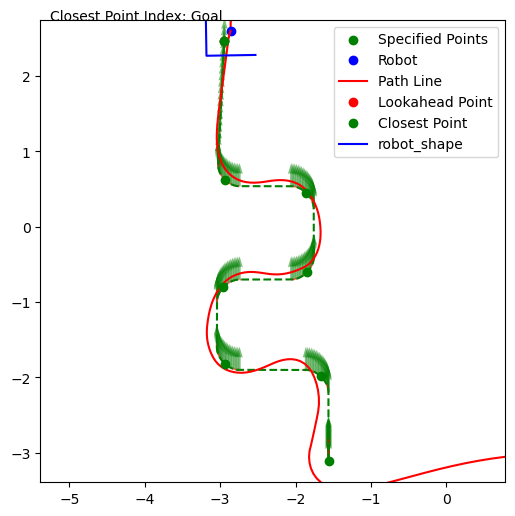

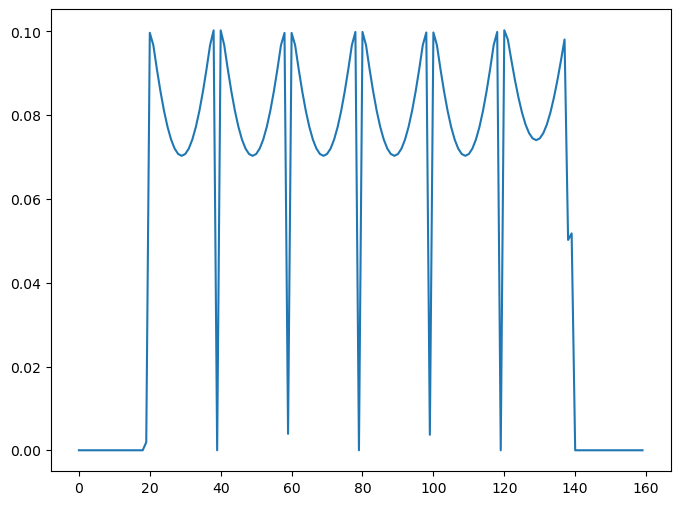

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import imageio

node = PurePursuitNode()

path_number = 1

path_file = f"../csv/path{path_number}.csv"
indices_and_commands_file = f"../csv/indices_and_commands{path_number}.csv"

# 経路データの読み込み
path_data = np.loadtxt(path_file, delimiter=',', skiprows=1)
path_x = path_data[:, 0]
path_y = path_data[:, 1]
path_theta = path_data[:, 2]
path = np.column_stack((path_x, path_y, path_theta))

tangents = node.compute_tangents(path)
node.angles, node.max_angle = node.compute_angles(tangents)

indices_and_commands = np.loadtxt(indices_and_commands_file, delimiter=',', skiprows=1)
indices = indices_and_commands[:, 0].astype(int)

# シミュレーションパラメータの設定
dt = 0.1  # シミュレーションのタイムステップ
node.dt = dt
total_time = 20  # シミュレーションの総時間
num_steps = int(total_time / dt)

# ロボットの初期位置
robot_position = np.array([1.5, -3.0])
theta = 0.0
# theta = 1.57
# ロボットの軌跡を記録するためのリスト
robot_path_x, robot_path_y = [], []

speed = 1.0  # ロボットの速度
current_speed = speed
lookahead_distance = 0.5  # ルックアヘッド距離
current_LA_dist = lookahead_distance
lookahead_point = robot_position
distance_threshold = 0.2  # 距離閾値
index = 0 # index of lookahead distance

# シミュレーション中にロボットの速度ベクトルを更新するための変数
robot_velocity_vector = np.array([0.0, 0.0])  # 初期速度ベクトル
target_velocity_vector = None
tau = 0.4  # 時間定数（適宜調整する）
P_gain = 0.5 # P gain for P control
node.path_p_gain = P_gain
closest_point = np.array([0.0, 0.0, 0.0])
current_omega = 0.0
target_omega = 0.0
previous_index = 0

# フェンスの描画に必要な座標を定義
fence_points = np.array([
    [0, 1], [1, 1],   # 壁1
    [1, 2], [2, 2],   # 壁2
    [0, 3], [1, 3]    # 売3
])
outer_fence = np.array([[0, 0], [0, 4], [2, 4], [2, 0], [0, 0]])

# アニメーションの準備
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(path_x, path_y, 'g--')  # 経路をプロット
plt.quiver(path_x, path_y, -np.sin(path_theta), np.cos(path_theta), scale=20, color='g', alpha=0.5)
plt.quiver(path_x, path_y, tangents[:, 0], tangents[:, 1], scale=40, color='r', alpha=0.5, linewidth=0.5)
plt.scatter(path[indices, 0], path[indices, 1], color='g', zorder=5, label='Specified Points')
# ax.plot(outer_fence[:, 0], outer_fence[:, 1], 'k-')  # 外枠の描画
# ax.plot(fence_points[[0, 1], 0], fence_points[[0, 1], 1], 'k-', linewidth=2)  # 壁1
# ax.plot(fence_points[[2, 3], 0], fence_points[[2, 3], 1], 'k-', linewidth=2)  # 壁2
# ax.plot(fence_points[[4, 5], 0], fence_points[[4, 5], 1], 'k-', linewidth=2)  # 壁3
robot_plot, = ax.plot([], [], 'bo', label='Robot')  # ロボットの位置をプロット
path_line, = ax.plot([], [], 'r-', label='Path Line')  # ロボットの軌跡をプロット
current_arrow = None
current_vel_arrow = None
lookahead_circle = plt.Circle(robot_position, lookahead_distance, fill=False, color='blue', linestyle='--')
ax.add_artist(lookahead_circle)
lookahead_point_plot, = ax.plot([], [], 'ro', label='Lookahead Point')  # 先行点をプロット
closest_point_plot, = ax.plot([], [], 'go', label='Closest Point')  # 最も近い点をプロット
robot_square, = ax.plot([], [], 'b-', label='robot_shape') # robot plot
text_display = ax.text(0.02, 1.0, '', transform=ax.transAxes) # テキスト表示
ax.axis('equal')
ax.legend()

def init():
    global current_arrow
    # 初期化時に描画する内容を定義する
    if current_arrow is not None:
        current_arrow.remove()
    current_arrow = None
    return []

# アニメーション更新関数
def animate(i):
    global robot_position, theta
    global robot_velocity_vector, target_velocity_vector, current_omega, target_omega
    global lookahead_point, index, closest_point, previous_index
    global current_LA_dist, current_speed
    global current_arrow, current_vel_arrow

    pose_vector = [0.0, 0.0]  # ここで初期化
    # 先行点と目標速度ベクトルを計算
    lookahead_point, closest_point, node.closest_index = node.find_lookahead_point(
        robot_position, path, index, current_LA_dist)
    if node.closest_index > len(path) - 3:
        target_vel_omega = np.array([0.0, 0.0, 0.0])
    else:
        try:
            target_vel_omega = node.compute_velocity(
                np.hstack((robot_position, theta)), lookahead_point, closest_point, current_speed)
        except:
            target_vel_omega = np.array([0.0, 0.0, 0.0])
    # テキストの更新
    if node.closest_index in indices:
        previous_index = node.closest_index
        if node.closest_index == indices[-1]:
            text_display.set_text('Closest Point Index: Goal')
        else:
            text_display.set_text('Closest Point Index: {}'.format(node.closest_index))
    else:
        text_display.set_text('Closest Point Index: {}'.format(previous_index))
    target_velocity_vector = target_vel_omega[:2]
    target_omega = target_vel_omega[2]
    # target_velocity_vector = np.dot(rotation_matrix(theta), target_velocity_vector)
    target_velocity_vector[0] = target_vel_omega[0] * np.cos(theta) - target_vel_omega[1] * np.sin(theta)
    target_velocity_vector[1] = target_vel_omega[0] * np.sin(theta) + target_vel_omega[1] * np.cos(theta)
    # ロボットの位置を更新
    robot_position, robot_velocity_vector, theta = update_position(robot_position, robot_velocity_vector, current_omega, target_velocity_vector, target_omega, dt, tau, theta)
    pose_vector = [-np.sin(theta), np.cos(theta)]

    if lookahead_point is not None:
        current_speed, current_LA_dist = node.change_speed_lookahead_distance(path, lookahead_distance, current_LA_dist, speed, current_speed, node.angles, node.max_angle, closest_point, node.closest_index)
        lookahead_point_plot.set_data([lookahead_point[0]], [lookahead_point[1]]) # 先行点をプロット
        closest_point_plot.set_data([closest_point[0]], [closest_point[1]]) # 最も近い点をプロット
        # ルックアヘッド円を更新
        lookahead_circle.center = robot_position
        lookahead_circle.radius = current_LA_dist
    # ロボットの軌跡に現在位置を追加
    robot_path_x.append(robot_position[0])
    robot_path_y.append(robot_position[1])
    path_line.set_data(robot_path_x, robot_path_y) # ロボットの軌跡をプロット
    # arrow settings
    if current_arrow is not None:
        current_arrow.remove()  # 前の矢印を削除
    current_arrow = patches.Arrow(robot_position[0], robot_position[1], pose_vector[0], pose_vector[1], width=0.05, color='red') # 新しい矢印を描画
    ax.add_patch(current_arrow)
    if current_vel_arrow is not None:
        current_vel_arrow.remove()  # 前の矢印を削除
    current_vel_arrow = patches.Arrow(robot_position[0], robot_position[1], robot_velocity_vector[0], robot_velocity_vector[1], width=0.05, color='blue') # 新しい矢印を描画
    ax.add_patch(current_vel_arrow)
    _, robot_vertices = calculate_rotated_vertices(robot_position, size=0.65, angle=theta) # ロボットの四角形の頂点を計算
    robot_square.set_data([robot_vertices[:, 0]], [robot_vertices[:, 1]]) # ロボットの四角形を描画
    robot_plot.set_data([robot_position[0]], [robot_position[1]]) # ロボットの位置をプロット
    return robot_plot, path_line, lookahead_circle, lookahead_point_plot, closest_point_plot, robot_square, text_display

# アニメーションの実行
ani = FuncAnimation(fig, animate, frames=num_steps, interval=dt*1000, blit=False)

# GIFとして保存
gif_path = 'omniwheel_robot_simulation.gif'
ani.save(gif_path, writer='pillow', fps=30)

# Colab環境でGIFを表示する場合は以下を実行
from IPython.display import Image
Image(open(gif_path, 'rb').read())

plt.figure(figsize=(8, 6))
plt.plot(node.angles)

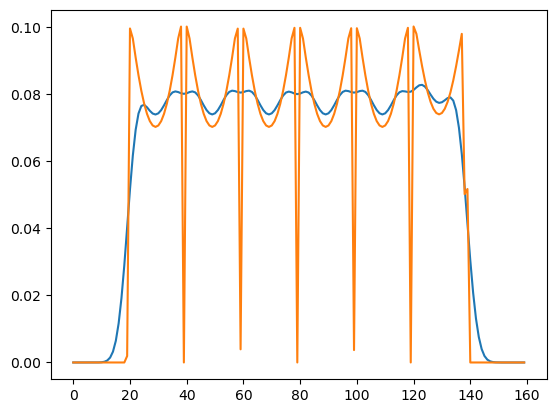

In [31]:
from scipy.ndimage import gaussian_filter1d

filtered_angles = gaussian_filter1d(node.angles, sigma=3)
plt.plot(filtered_angles, label='Filtered Angles')
plt.plot(node.angles, label='Original Angles')
plt.show()

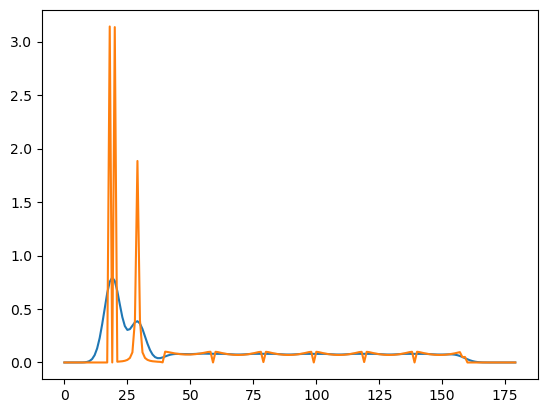

In [29]:
from scipy.ndimage import gaussian_filter1d

filtered_angles = gaussian_filter1d(node.angles, sigma=3)
plt.plot(filtered_angles, label='Filtered Angles')
plt.plot(node.angles, label='Original Angles')
plt.show()

# efficientilize finding lookahead point

In [50]:
import numpy as np
from numpy.typing import NDArray

def current_find_lookahead_point (
        robot_pose: NDArray[np.float64], 
        path_data: NDArray[np.float64], 
        lookahead_distance: float,
        previous_index: int
    ) -> tuple[NDArray[np.float64], int]:
    closest_index = previous_index
    min_distance = float('inf')
    lookahead_point = None
    search_range = 50  # 前後の検索範囲

    # 最も近い点の検索
    for i in range(max(0, previous_index - search_range), min(len(path_data), previous_index + search_range)):
        point = path_data[i]
        distance = np.linalg.norm(robot_pose[:2] - point[:2])
        if distance < min_distance:
            min_distance = distance
            closest_point = point
            closest_index = i

    # 先行点の計算
    for i in range(closest_index, min(len(path_data) - 1, closest_index + search_range)):
        point = path_data[i]
        to_vector = robot_pose[:2] - point[:2]
        dot_product = np.dot(to_vector, path_data[i+1][:2] - point[:2])
        distance = np.linalg.norm(to_vector)
        if distance >= lookahead_distance and dot_product < 0.0:
            lookahead_point = point
            break

    if lookahead_point is None:
        lookahead_point = path_data[min(len(path_data) - 1, closest_index + search_range)][:2]

    return closest_point, lookahead_point, closest_index

In [72]:
def interpolate_point(p1: NDArray[np.float64], p2: NDArray[np.float64], ratio: float) -> NDArray[np.float64]:
    """2点間を指定された比率で補間する"""
    return p1 + ratio * (p2 - p1)

def modified_find_lookahead_point (
        robot_pose: NDArray[np.float64], 
        path_data: NDArray[np.float64], 
        lookahead_distance: float,
        previous_index: int
    ) -> tuple[NDArray[np.float64], NDArray[np.float64], int]:
    closest_index = previous_index
    lookahead_point = None
    # search_range = 50  # 前後の検索範囲

    # 最も近い点の検索
    start_index = previous_index # 検索範囲の開始インデックス
    # end_index = min(len(path_data), previous_index + search_range) # 検索範囲の終了インデックス
    distances = np.linalg.norm(path_data[:, :2] - robot_pose[:2], axis=1)
    closest_index = np.argmin(distances[start_index:]) + start_index
    closest_point = path_data[closest_index]

    # 先行点の計算
    # lookahead_candidate_index = np.where((distances - lookahead_distance)[closest_index:closest_index + search_range] < 0.0)[0][-1] + closest_index
    # print(lookahead_candidate_index)
    # prev_distance = distances[lookahead_candidate_index]
    # current_distance = distances[lookahead_candidate_index + 1]
    # ratio = (lookahead_distance - prev_distance) / (current_distance - prev_distance)
    # lookahead_point = interpolate_point(
    #     path_data[lookahead_candidate_index][:2], 
    #     path_data[lookahead_candidate_index + 1][:2], 
    #     ratio)
    lookahead_index = np.argmin(distances[closest_index:] - lookahead_distance) + closest_index
    lookahead_index = max(lookahead_index, closest_index)
    lookahead_point = path_data[lookahead_index]

    return closest_point, lookahead_point, closest_index

In [168]:
import numpy as np
import time

# ここに現在のfind_lookahead_point()関数と改良されたmodified_find_lookahead_point()関数を定義
node = PurePursuitNode()

# テストデータの準備
robot_pose = np.array([1.5, -3.15, 0.0])
previous_index = 0

# 現在の関数の計算時間を測定
start_time = time.time()
closest_point_current, lookahead_point_current, closest_index_current = current_find_lookahead_point(
    robot_pose, path_data, lookahead_distance, previous_index)
end_time = time.time()
current_duration = end_time - start_time

# 改良された関数の計算時間を測定
start_time = time.time()
closest_point_modified, lookahead_point_modified, closest_index_modified = node.find_lookahead_point(
    robot_pose, path_data, previous_index, lookahead_distance)
end_time = time.time()
modified_duration = end_time - start_time

# 結果の出力
print(f"Current function duration: {current_duration} seconds")
print(f"Modified function duration: {modified_duration} seconds")
print(f"time ratio: {current_duration / modified_duration}")

Current function duration: 0.0010828971862792969 seconds
Modified function duration: 0.0002231597900390625 seconds
time ratio: 4.852564102564102
